<a href="https://www.kaggle.com/code/prnvthkkr/hate-speech-detection?scriptVersionId=208943710" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# # Getting data from file

In [1]:

import numpy as np     
import pandas as pd 

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression  
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt

import nltk
from nltk.util import pr
from nltk.tokenize import word_tokenize      
from nltk.corpus import stopwords            
stopword = set(stopwords.words('english'))

import tensorflow as tf
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D

import seaborn as sns


import re
import string

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

2024-11-22 05:44:37.306382: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-22 05:44:37.306499: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-22 05:44:37.435714: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


/kaggle/input/hate-speech-and-offensive-language-dataset/labeled_data.csv
/kaggle/input/glove6b100dtxt/glove.6B.100d.txt


# # Analizing amazing data

In [2]:
twitts_data = pd.read_csv("/kaggle/input/hate-speech-and-offensive-language-dataset/labeled_data.csv")

class_data = twitts_data['class'].value_counts()
class_data

class
1    19190
2     4163
0     1430
Name: count, dtype: int64

# Count

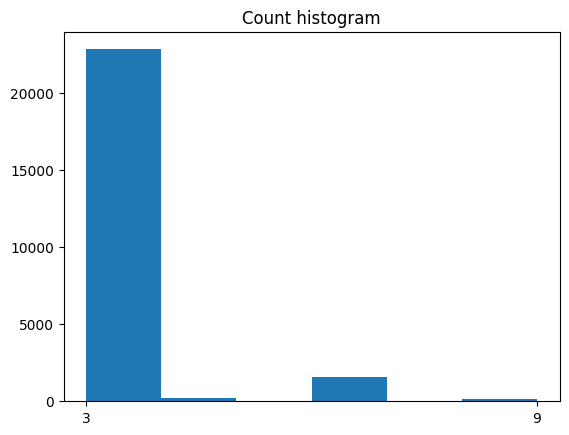

In [3]:
plt.hist(twitts_data['count'], bins = 6)
plt.title('Count histogram')
plt.xticks([3,9], [3,9])
plt.show()

# Hate speech

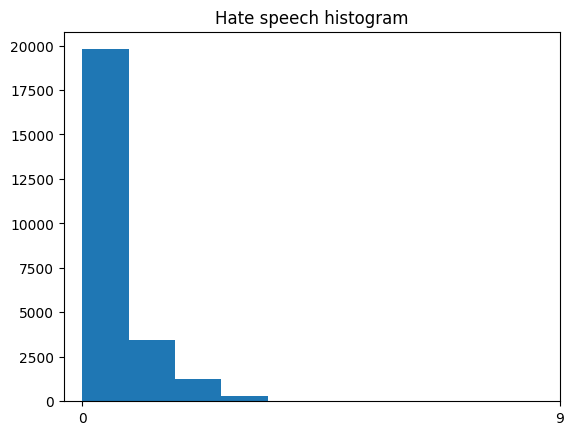

In [4]:
plt.hist(twitts_data['hate_speech'], bins = 8)
plt.title('Hate speech histogram')
plt.xticks([0,9], [0,9])
plt.show()

# Offensive language

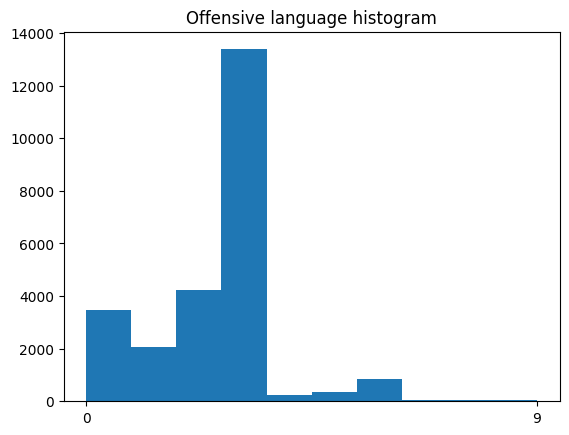

In [5]:
plt.hist(twitts_data['offensive_language'], bins = 10)
plt.title('Offensive language histogram')
plt.xticks([0,9], [0,9])
plt.show()

# Neither

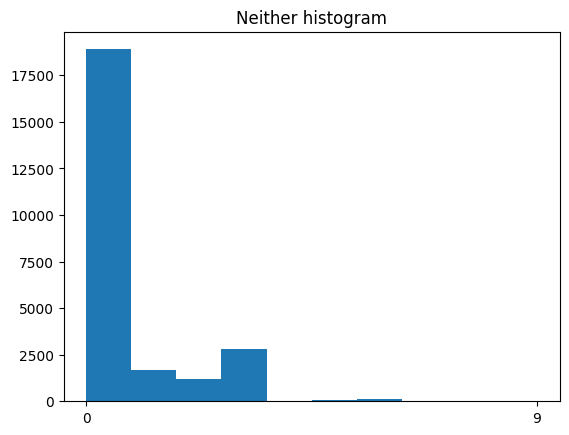

In [6]:
plt.hist(twitts_data['neither'], bins = 10)
plt.title('Neither histogram')
plt.xticks([0,9], [0,9])
plt.show()

# Class

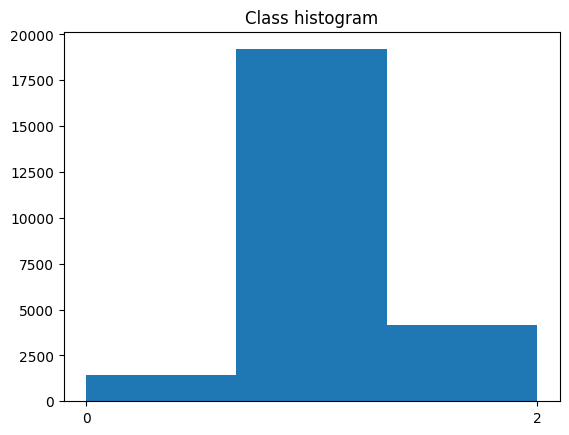

In [7]:
plt.hist(twitts_data['class'], bins = 3)
plt.title('Class histogram')
plt.xticks([0,2], [0,2])
plt.show()

0 - hate speech
1 - offensive language
2 - netiher

# # Code preperation

In [8]:
def clean(text): 
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub(r"\@w+|\#",'',text)
    text = re.sub(r"[^\w\s]",'',text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    tweet_tokens = word_tokenize(text)
    filtered_tweets=[w for w in tweet_tokens if not w in stopword] #removing stopwords
    return " ".join(filtered_tweets)

In [9]:

twitts_data.tweet = twitts_data['tweet'].apply(clean)
text_data = twitts_data.drop_duplicates("tweet")

vect=TfidfVectorizer(ngram_range=(1,3)).fit(text_data['tweet'])


# Divide data for training and test

In [10]:

X = text_data['tweet']
Y = text_data['class']
X = vect.transform(X) #Transformacja danych X

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15, 
                                                    random_state=42)


In [11]:
print("X_train count: ",X_train.size)
print("X_test count: ",X_test.size)

X_train count:  455109
X_test count:  79919


# Logistic regression

In [12]:
logreg = LogisticRegression(max_iter = 300)
logreg.fit(X_train, Y_train)

logreg_predict = logreg.predict(X_test) 

In [13]:
print(classification_report(Y_test, logreg_predict))

              precision    recall  f1-score   support

           0       0.73      0.04      0.07       211
           1       0.85      0.99      0.91      2843
           2       0.88      0.50      0.64       622

    accuracy                           0.85      3676
   macro avg       0.82      0.51      0.54      3676
weighted avg       0.85      0.85      0.82      3676



# Making tokens for training and test data

In [14]:
X = text_data['tweet']
Y = text_data['class']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15, 
                                                    random_state=42)

x = X_train.values
y = Y_train.values

x_tokenizer = text.Tokenizer(20000)
x_tokenizer.fit_on_texts(list(x))

x_tokenized = x_tokenizer.texts_to_sequences(x)
x_train_val= sequence.pad_sequences(x_tokenized, maxlen=512)

x_test_tokenized = x_tokenizer.texts_to_sequences(X_test.values)
x_test = sequence.pad_sequences(x_test_tokenized,maxlen=512)

# Glove model loading

In [15]:
embedding_dim =100
embeddings_index = dict()
f = open('/kaggle/input/glove6b100dtxt/glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype = 'float32')
    embeddings_index[word]= coefs
f.close()
print(f'Glove model words count {len(embeddings_index)} word vectors')

Glove model words count 400000 word vectors


In [16]:
embedding_matrix= np.zeros((20000,embedding_dim))
for word, index in x_tokenizer.word_index.items():
    if index>20000-1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index]= embedding_vector

In [17]:
y_train_plus_val =  tf.keras.utils.to_categorical(y, num_classes=3)
y_test =  tf.keras.utils.to_categorical(Y_test.values, num_classes=3)
y_train_plus_val

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.]])

In [18]:
model = Sequential()
model.add(Embedding(20000,
                    embedding_dim,
                    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                    trainable=False))

model.add(Dropout(0.2))

model.add(Conv1D(64,2,padding='valid',activation='relu'))
model.add(MaxPooling1D())
model.add(Conv1D(64,2,padding='valid',activation='relu'))
model.add(MaxPooling1D())

model.add(Conv1D(32,2,padding='valid',activation='relu'))
model.add(MaxPooling1D())
model.add(Conv1D(32,2,padding='valid',activation='relu'))
model.add(GlobalMaxPooling1D())

model.add(Dense(16, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(3, activation='softmax'))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │   0 (unbuilt) │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [19]:
import tensorflow.keras.backend as K

# Funkcie które pozwalały na trenowanie modelu od kątem optymalizacji wartości f1-score w przypadku modelu CNN
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + 
    K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

#dodajemy nowe metryki, które polepszają f1-score
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy', f1_m, precision_m, recall_m])

In [20]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_accuracy',  
    patience=2,              
    restore_best_weights=True  
)

history = model.fit(x_train_val, y_train_plus_val, batch_size= 64, validation_split=0.2, epochs=10)



Epoch 1/10
 13/261 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.7655 - f1_m: 0.2971 - loss: 0.8992 - precision_m: 0.6488 - recall_m: 0.2362

I0000 00:00:1732254338.382649      72 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


261/261 ━━━━━━━━━━━━━━━━━━━━ 21s 36ms/step - accuracy: 0.7804 - f1_m: 0.7035 - loss: 0.6661 - precision_m: 0.7855 - recall_m: 0.6649 - val_accuracy: 0.8322 - val_f1_m: 0.8273 - val_loss: 0.4743 - val_precision_m: 0.8447 - val_recall_m: 0.8109
Epoch 2/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8386 - f1_m: 0.8329 - loss: 0.4511 - precision_m: 0.8552 - recall_m: 0.8122 - val_accuracy: 0.8488 - val_f1_m: 0.8475 - val_loss: 0.4351 - val_precision_m: 0.8581 - val_recall_m: 0.8372
Epoch 3/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8755 - f1_m: 0.8729 - loss: 0.3903 - precision_m: 0.8885 - recall_m: 0.8581 - val_accuracy: 0.8569 - val_f1_m: 0.8553 - val_loss: 0.4118 - val_precision_m: 0.8677 - val_recall_m: 0.8434
Epoch 4/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8888 - f1_m: 0.8874 - loss: 0.3424 - precision_m: 0.8979 - recall_m: 0.8772 - val_accuracy: 0.8543 - val_f1_m: 0.8523 - val_loss: 0.4413 - val_precision_m: 0.8638 - val_recall_m: 0.8412
E

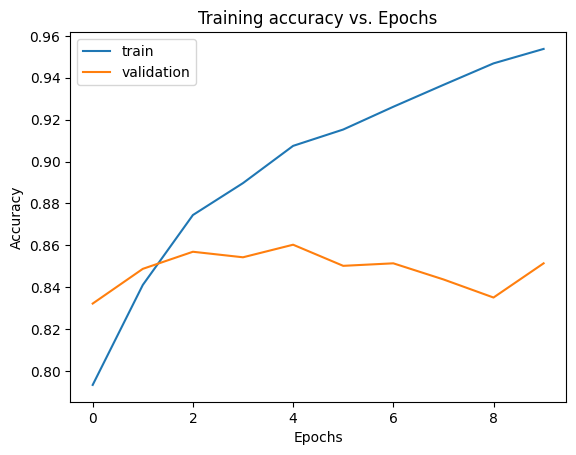

In [21]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training accuracy vs. Epochs')
plt.legend()
plt.show()

In [22]:
model.evaluate(x_test,y_test, batch_size = 64)

58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8487 - f1_m: 0.8518 - loss: 0.7553 - precision_m: 0.8564 - recall_m: 0.8473


[0.7315071225166321,
 0.8482045531272888,
 0.8503679633140564,
 0.8545433282852173,
 0.8462899923324585]

In [23]:
y_pred = model.predict(x_test)
y_pred_raport = y_pred.argmax(axis = 1)
y_pred_raport

115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


array([1, 1, 1, ..., 1, 1, 1])

In [24]:
y_test_raport = y_test.argmax(axis = 1)
y_test_raport

array([1, 1, 2, ..., 1, 1, 1])

In [25]:
print(classification_report(y_test_raport, y_pred_raport))

              precision    recall  f1-score   support

           0       0.43      0.18      0.26       211
           1       0.87      0.95      0.91      2843
           2       0.76      0.59      0.67       622

    accuracy                           0.85      3676
   macro avg       0.69      0.58      0.61      3676
weighted avg       0.83      0.85      0.83      3676



# **Training little transformer model using BERT pretrained encoder**

In [26]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression  
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt

import nltk
from nltk.util import pr
from nltk.tokenize import word_tokenize      
from nltk.corpus import stopwords            
stopword = set(stopwords.words('english'))

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model

from transformers import BertTokenizer, TFBertModel

from keras.layers import LSTM
from keras.layers import Conv1D, MaxPooling1D
from keras.layers import Dropout

import seaborn as sns
import re
import string

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/hate-speech-and-offensive-language-dataset/labeled_data.csv
/kaggle/input/glove6b100dtxt/glove.6B.100d.txt


In [27]:
def clean(text): 
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub(r"\@w+|\#",'',text)
    text = re.sub(r"[^\w\s]",'',text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    tweet_tokens = word_tokenize(text)
    filtered_tweets = [w for w in tweet_tokens if not w in stopword] #removing stopwords
    return " ".join(filtered_tweets)

# Pobranie i wyczyszczenie danych
tweets_data = pd.read_csv("/kaggle/input/hate-speech-and-offensive-language-dataset/labeled_data.csv")
tweets_data.tweet = tweets_data['tweet'].apply(clean)
tweets_data = tweets_data.drop_duplicates("tweet")

tweets = tweets_data['tweet']
classes = tweets_data['class']

class_encoder = LabelEncoder()
classes = class_encoder.fit_transform(classes)

tweets_train, tweets_test, classes_train, classes_test = train_test_split(tweets, classes, test_size=0.10, random_state=42)

tweets_train = tweets_train.values
tweets_test = tweets_test.values

classes_train = tf.cast(classes_train, tf.float32)
classes_test = tf.cast(classes_test, tf.float32)

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained("bert-base-uncased")

def encode_tweets(tweets):
    batch_size = 1000
    embeddings = []
    for i in range(0, len(tweets), batch_size):
        batch_texts = tweets[i:i+batch_size]
        tokenized_tweets = tokenizer(
            batch_texts.tolist(),
            max_length = 128,
            padding = True,
            truncation = True,
            return_tensors = 'tf'
        )
        inputs = {'input_ids': tokenized_tweets['input_ids'], 'attention_mask': tokenized_tweets['attention_mask']}
        outputs = bert_model(**inputs)
        batch_embeddings = outputs.last_hidden_state[:, 0, :]
        embeddings.append(batch_embeddings)
    return tf.concat(embeddings, axis = 0)

embeddings_train = encode_tweets(tweets_train)
embeddings_test = encode_tweets(tweets_test)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Epoch 1/20
106/276 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7837 - loss: 0.6275

W0000 00:00:1732254452.778193      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8054 - loss: 0.5473

W0000 00:00:1732254454.526737      73 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1732254454.895037      74 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


276/276 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.8055 - loss: 0.5471 - val_accuracy: 0.8422 - val_loss: 0.4381
Epoch 2/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8436 - loss: 0.4233 - val_accuracy: 0.8474 - val_loss: 0.4176
Epoch 3/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8522 - loss: 0.3916 - val_accuracy: 0.8477 - val_loss: 0.4061
Epoch 4/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8525 - loss: 0.3860 - val_accuracy: 0.8372 - val_loss: 0.4296
Epoch 5/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8569 - loss: 0.3768 - val_accuracy: 0.8497 - val_loss: 0.4038
Epoch 6/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8681 - loss: 0.3607 - val_accuracy: 0.8438 - val_loss: 0.4125
Epoch 7/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8687 - loss: 0.3540 - val_accuracy: 0.8560 - val_loss: 0.3989
Epoch 8/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8731 - loss: 0.3393 - val_accuracy: 0.8486 - val_

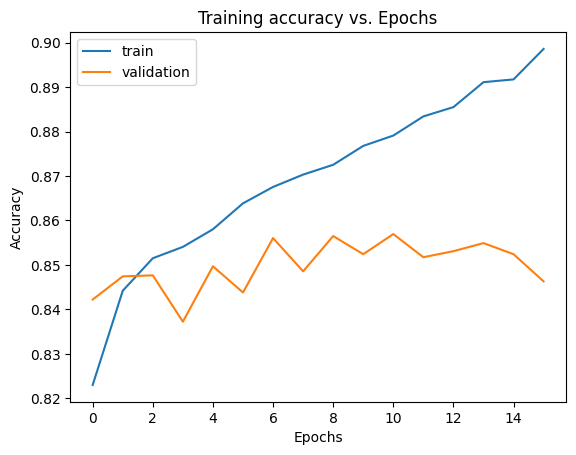

44/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step   

W0000 00:00:1732254463.700040      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
              precision    recall  f1-score   support

         0.0       0.38      0.12      0.19       144
         1.0       0.89      0.95      0.92      1913
         2.0       0.74      0.68      0.71       394

    accuracy                           0.86      2451
   macro avg       0.67      0.58      0.60      2451
weighted avg       0.83      0.86      0.84      2451



In [28]:
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping


def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + 
    K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

early_stopping = EarlyStopping(
    monitor='val_accuracy',  
    patience=5,              
    restore_best_weights=True  
)

model = Sequential()
model.add(Input(shape=(768,)))
model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(3, activation = 'softmax'))

model.compile(optimizer = 'Adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

history = model.fit(embeddings_train, classes_train, epochs = 20, batch_size = 64, validation_split = 0.2, 
                   callbacks = [early_stopping])

plt.plot(history.history['accuracy'], label = 'train')
plt.plot(history.history['val_accuracy'], label = 'validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training accuracy vs. Epochs')
plt.legend()
plt.show()

predictions = model.predict(embeddings_test)
predictions = predictions.argmax(axis = 1)

print(classification_report(classes_test, predictions))



In [29]:

# Define a mapping from class numbers to labels
class_mapping = {
    0: "Hate speech",
    1: "Offensive language",
    2: "neither"
}

# Function to preprocess and predict a single input
def predict_single_input(text):
    # Step 1: Clean the input text
    cleaned_text = clean(text)
    
    # Step 2: Encode the cleaned text with BERT tokenizer
    tokenized_tweet = tokenizer(
        [cleaned_text],
        max_length=128,
        padding=True,
        truncation=True,
        return_tensors='tf'
    )
    
    # Prepare inputs for the BERT model
    inputs = {
        'input_ids': tokenized_tweet['input_ids'],
        'attention_mask': tokenized_tweet['attention_mask']
    }
    
    # Step 3: Get the BERT embeddings
    bert_output = bert_model(**inputs)
    embedding = bert_output.last_hidden_state[:, 0, :]
    
    # Step 4: Predict using the trained model
    prediction = model.predict(embedding)
    predicted_class = prediction.argmax(axis=1)[0]
    
    # Step 5: Decode the predicted class to human-readable label
    predicted_label = class_mapping[predicted_class]
    
    return predicted_label

# Example usage
text_input = ""
predicted_label = predict_single_input(text_input)
print(f"Predicted Label: {predicted_label}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
Predicted Label: Hate speech


# 